# Module

In [1]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
%%time

import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import *

import optuna
from xgboost import XGBRegressor, callback
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.linear_model import Ridge

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

import warnings

warnings.filterwarnings('ignore')

CPU times: user 6.08 ms, sys: 385 µs, total: 6.47 ms
Wall time: 5.62 ms


In [3]:
SEED=2024

np.random.seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Func

In [4]:
%%time

def load_data():    
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')    
    all_df = pd.concat([train, test], sort=False).reset_index(drop=True)
    return train, test, all_df

def fill_nan_values(df):
    num_cols = [col for col in df.select_dtypes(exclude='object').columns if col != 'Premium Amount']
    cat_cols = df.select_dtypes(include='object').columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    for col in cat_cols:
        df[col] = df[col].fillna('missing')
    return df
    
def skewed(df, all_df):
    pt = PowerTransformer(method='yeo-johnson')
    pt.fit(df[['Annual Income']])
    all_df['transformed_Annual_Income'] = pt.transform(all_df[['Annual Income']])
    # all_df['log_Annual_Income'] = np.log1p(all_df['Annual Income'])
    return all_df
    
def date(df):
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7    
    df.drop('Policy Start Date', axis=1, inplace=True)
    return df

def get_nan_cols(df):
    nan_cols = ['Marital Status', 'Customer Feedback', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
    for col in nan_cols:
        col_name = col + '_NA'
        df[col_name] = df[col].isnull().astype(int)
    return df

def get_encoding(df):
    def encode_ordinal(df):
        educ = {"High School":0, "Bachelor's":1, "Master's":2, "PhD":3}
        policy = {'Basic':0, 'Comprehensive':1, 'Premium':2}
        exerc = {'Rarely':0, 'Daily':1, 'Weekly':2, 'Monthly': 3}
        # feedback = {'Poor':0, 'Average':1, 'Good':2}

        df['Education Level'] = df['Education Level'].map(educ)
        df['Policy Type'] = df['Policy Type'].map(policy)
        df['Exercise Frequency'] = df['Exercise Frequency'].map(exerc)
        # df['Customer Feedback'] = df['Customer Feedback'].map(feedback)
        df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
        df['Smoking Status'] = df['Smoking Status'].map({'Yes':1, 'No':0})
        return df
    
    def target_encoder(df):
        train = df[~df['Premium Amount'].isnull()]
        test = df[df['Premium Amount'].isnull()]
        encoder = TargetEncoder()
        categorical_cols = ['Marital Status', 'Customer Feedback']
        train[categorical_cols] = encoder.fit_transform(train[categorical_cols], train['Premium Amount'])
        test[categorical_cols] = encoder.transform(test[categorical_cols])
        df = pd.concat([train, test], sort=False).reset_index(drop=True)
        return df

    def one_hot_dummies(df, categorical):
        oh = pd.get_dummies(df[categorical])
        df = df.drop(categorical, axis=1)
        return pd.concat([df, oh], axis=1)
        return df

    df = encode_ordinal(df)
    df = target_encoder(df)

    categorical_features = df.select_dtypes(include='object').columns
    df = one_hot_dummies(df, categorical_features)
    return df

def add_new_features(df):
    df['Income_Dependents Ratio'] = df['Annual Income'] / (df['Number of Dependents'].fillna(0) + 1)
    df['Income_per_Dependent'] = df['Annual Income'] / (df['Number of Dependents'] + 1)
    df['CreditScore_InsuranceDuration'] = df['Credit Score'] * df['Insurance Duration']
    df['Health_Risk_Score'] = df['Smoking Status'].apply(lambda x: 1 if x == 'Smoker' else 0) + \
                                df['Exercise Frequency'].apply(lambda x: 1 if x == 'Low' else (0.5 if x == 'Medium' else 0)) + \
                                (100 - df['Health Score']) / 20
    df['Credit_Health_Score'] = df['Credit Score'] * df['Health Score']
    df['Health_Age_Interaction'] = df['Health Score'] * df['Age']

    df['contract_length'] = pd.cut(
        df["Insurance Duration"].fillna(99),  
        bins=[-float('inf'), 1, 3, float('inf')],  
        labels=[0, 1, 2]  
    ).astype(int)

    df['Age_Income'] = df['Age'] * df['Annual Income']

    # df["Annual_Income_Health_Score_Ratio"] = df["Health Score"] / df["Annual Income"]
    # df["Annual_Income_Age_Ratio"] = df["Annual Income"] / df["Age"]
    # df["Credit_Age"] = df["Credit Score"] / df["Age"]
    # df["Vehicle_Age_Insurance_Duration"] = df["Vehicle Age"] / df["Insurance Duration"]
    return df

def prep():
    train, test, all_df = load_data()

    all_df = skewed(train, all_df)
    all_df = date(all_df)
    all_df = get_nan_cols(all_df)
    # all_df = fill_nan_values(all_df)
    all_df = get_encoding(all_df)
    all_df = add_new_features(all_df)

    del all_df['Annual Income']
    
    train = all_df[~all_df['Premium Amount'].isnull()]
    test = all_df[all_df['Premium Amount'].isnull()]
    train.drop('id', axis=1, inplace=True)
    test.drop(['id', 'Premium Amount'], axis=1, inplace=True)
    return train, test, all_df

def prep_nan():
    train, test, all_df = load_data()

    all_df = skewed(train, all_df)
    all_df = date(all_df)
    all_df = get_nan_cols(all_df)
    all_df = fill_nan_values(all_df)
    all_df = get_encoding(all_df)
    all_df = add_new_features(all_df)

    del all_df['Annual Income']
    
    train = all_df[~all_df['Premium Amount'].isnull()]
    test = all_df[all_df['Premium Amount'].isnull()]
    train.drop('id', axis=1, inplace=True)
    test.drop(['id', 'Premium Amount'], axis=1, inplace=True)
    return train, test, all_df

train, test, all_df = prep()

CPU times: user 10.3 s, sys: 2 s, total: 12.3 s
Wall time: 13.3 s


In [5]:
train_nan, test_nan, all_df_nan = prep_nan()

In [6]:
train.head()

,Age,Gender,Marital Status,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Premium Amount,transformed_Annual_Income,Year,Day,Month,Week,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos,Group,Marital Status_NA,Customer Feedback_NA,Health Score_NA,Previous Claims_NA,Vehicle Age_NA,Credit Score_NA,Insurance Duration_NA,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Location_Rural,Location_Suburban,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House,Month_name_April,Month_name_August,Month_name_December,Month_name_February,Month_name_January,Month_name_July,Month_name_June,Month_name_March,Month_name_May,Month_name_November,Month_name_October,Month_name_September,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Income_Dependents Ratio,Income_per_Dependent,CreditScore_InsuranceDuration,Health_Risk_Score,Credit_Health_Score,Health_Age_Interaction,contract_length,Age_Income
0,19.0,1,1099.844389,1.0,1,22.598761,2,2.0,17.0,372.0,5.0,1098.892745,0,2,2869.0,-0.596487,2023,23,12,51,-9.510565e-01,0.309017,-2.449294e-16,1.000000e+00,-0.998717,-0.050649,195,0,0,0,0,0,0,0,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,5024.5,5024.5,1860.0,3.870062,8406.738970,429.376453,2,190931.0
1,39.0,1,1100.625116,3.0,2,15.569731,1,1.0,12.0,694.0,2.0,1094.350977,1,3,1483.0,0.336563,2023,12,6,24,-9.510565e-01,0.309017,1.224647e-16,-1.000000e+00,0.651372,-0.758758,169,0,0,0,0,0,0,0,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,7919.5,7919.5,1388.0,4.221513,10805.393307,607.219509,1,1235442.0
2,23.0,0,1100.625116,3.0,0,47.177549,2,1.0,14.0,NaN,3.0,1096.284299,1,2,567.0,0.140781,2023,30,9,39,-9.510565e-01,0.309017,-1.000000e+00,-1.836970e-16,-0.201299,0.979530,184,0,0,0,0,0,1,0,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,6400.5,6400.5,NaN,2.641123,NaN,1085.083634,1,588846.0
3,21.0,0,1099.844389,2.0,1,10.938144,0,1.0,0.0,367.0,1.0,1098.892745,1,1,765.0,2.088459,2024,12,6,24,-2.449294e-16,1.000000,1.224647e-16,-1.000000e+00,0.651372,-0.758758,217,0,0,0,0,0,0,0,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,47285.0,47285.0,367.0,4.453093,4014.298906,229.701027,0,2978955.0
4,21.0,0,1101.735535,1.0,1,20.376094,2,0.0,8.0,598.0,4.0,1098.892745,1,2,2022.0,0.555622,2021,1,12,48,5.877853e-01,-0.809017,-2.449294e-16,1.000000e+00,0.201299,0.979530,96,0,0,0,0,0,0,0,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,19825.5,19825.5,2392.0,3.981195,12184.903989,427.897966,2,832671.0


In [7]:
train.shape, test.shape, train_nan.shape, test_nan.shape

((1200000, 70), (800000, 69), (1200000, 71), (800000, 70))

# PCA

In [13]:
y_train = train['Premium Amount']
y_log = np.log1p(y_train)
y_log_nan = np.log1p(train_nan['Premium Amount'])

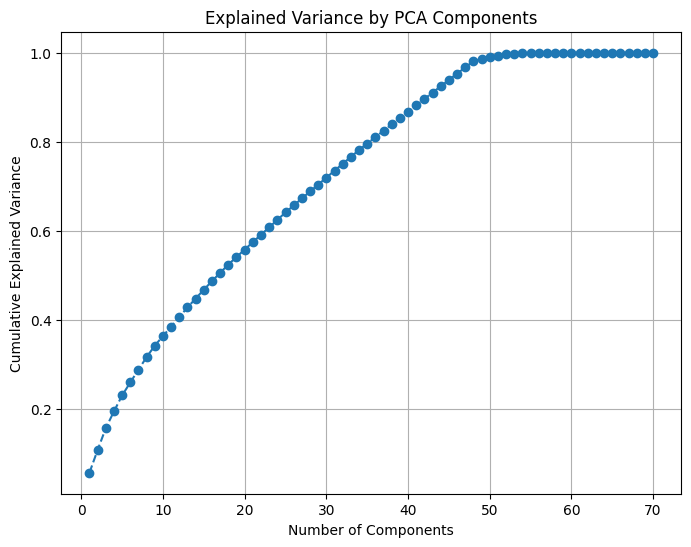

In [8]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_nan.drop('Premium Amount', axis=1))

pca = PCA()
pca.fit(scaled_data)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [22]:
%%time
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_nan.drop('Premium Amount', axis=1))
test_scaled = scaler.transform(test_nan)

pca = PCA(n_components=2)
train_pca = pca.fit_transform(scaled_data)
test_pca = pca.transform(test_scaled)

train_extended = np.hstack((train.drop('Premium Amount', axis=1), train_pca))
test_extended = np.hstack((test, test_pca))

CPU times: user 12.1 s, sys: 12.2 s, total: 24.4 s
Wall time: 2min 53s


In [15]:
%%time
x_train, x_val, y_train, y_val = train_test_split(train_pca, y_log_nan, test_size=0.2, random_state=SEED)
model = LGBMRegressor(n_estimators=1000, learning_rate=0.1, random_state=SEED)
model.fit(x_train, y_train, 
    eval_set=[(x_val, y_val)], 
    eval_metric='rmse',
    callbacks=[early_stopping(100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 45
[LightGBM] [Info] Start training from score 6.594502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	valid_0's rmse: 1.07972	valid_0's l2: 1.1658
CPU times: user 52.1 s, sys: 173 ms, total: 52.3 s
Wall time: 27 s


LGBMRegressor(n_estimators=1000, random_state=2024)

In [17]:
%%time
selector = SelectFromModel(model, threshold='mean', prefit=True)  # 평균 이상 중요도 기준으로 선택
selected_train = selector.transform(train_pca)
selected_test = selector.transform(test_pca)

print(selected_train.shape)

(1200000, 19)
CPU times: user 370 ms, sys: 48.3 ms, total: 418 ms
Wall time: 419 ms


In [18]:
%%time
train_extended_selected = np.hstack((train.drop(['Premium Amount'], axis=1), selected_train))
test_extended_selected = np.hstack((test, selected_test))

CPU times: user 2.96 s, sys: 2.41 s, total: 5.36 s
Wall time: 5.66 s


# Stacking

## LGBM

In [97]:
%%time

data = np.load('./data/pred_oof_data.npz')

lgbm_OOF = data['lgbm_OOF']
xgb_OOF = data['xgb_OOF']
cat_OOF = data['cat_OOF']
et_OOF = data['et_OOF']

lgbm_preds = data['lgbm_preds']
xgb_preds = data['xgb_preds']
cat_preds = data['cat_preds']
et_preds = data['et_preds']

OOF_std = data['OOF_std']
OOF_mean = data['OOF_mean']
OOF_min = data['OOF_min']
OOF_max = data['OOF_max']
pred_std = data['pred_std']
pred_mean = data['pred_mean']
pred_min = data['pred_min']
pred_max = data['pred_max']

train['income_credit'] = train['transformed_Annual_Income'] * train['Credit Score']
test['income_credit'] = test['transformed_Annual_Income'] * test['Credit Score']

stacked_train = np.column_stack((lgbm_OOF, xgb_OOF, cat_OOF, et_OOF, train['transformed_Annual_Income'], train['Credit Score']))
stacked_test = np.column_stack((lgbm_preds, xgb_preds, cat_preds, et_preds, test['transformed_Annual_Income'], test['Credit Score']))

CPU times: user 105 ms, sys: 15.9 ms, total: 121 ms
Wall time: 120 ms


In [50]:
%%time

def objective(trial):
    params = {
        'n_estimators': 500,
        'num_leaves': trial.suggest_int('num_leaves', 18, 26),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.04, log=True),
        'lambda_l1': trial.suggest_float('lambda_l1', 5, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1.0, 2.5),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.65),
        'subsample': trial.suggest_float('subsample', 0.5, 0.65),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1
    }

    lgbm_meta = LGBMRegressor(**params)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(stacked_train):
        x_train, x_val = stacked_train[train_idx], stacked_train[val_idx]
        y_train, y_val = y_log[train_idx], y_log[val_idx]

        lgbm_meta.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            eval_metric='rmse',
            callbacks=[early_stopping(100)]
        )
        preds = lgbm_meta.predict(x_val)
        rmse = root_mean_squared_error(y_val, preds)
        scores.append(rmse)

    return np.mean(scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=5)

[I 2024-12-31 15:19:11,766] A new study created in memory with name: no-name-cdba6469-270e-493f-ae29-b08c7a298b41


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[400]	valid_0's rmse: 1.04593	valid_0's l2: 1.09398
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's rmse: 1.04501	valid_0's l2: 1.09205
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[477]	valid_0's rmse: 1.04605	valid_0's l2: 1.09423
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[435]	valid_0's rmse: 1.04387	valid_0's l2: 1.08967
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[372]	valid_0's rmse: 1.04549	valid_0's l2: 1.09305


[I 2024-12-31 15:20:43,164] Trial 0 finished with value: 1.045272363402227 and parameters: {'num_leaves': 21, 'max_depth': 6, 'learning_rate': 0.03321866147099672, 'lambda_l1': 7.993292420985183, 'lambda_l2': 1.2340279606636548, 'min_child_samples': 11, 'colsample_bytree': 0.50871254182523, 'subsample': 0.6299264218662403}. Best is trial 0 with value: 1.045272363402227.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.04598	valid_0's l2: 1.09408
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.04506	valid_0's l2: 1.09215
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's rmse: 1.04607	valid_0's l2: 1.09427
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[497]	valid_0's rmse: 1.04389	valid_0's l2: 1.0897
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's rmse: 1.04548	valid_0's l2: 1.09302


[I 2024-12-31 15:22:10,208] Trial 1 finished with value: 1.0452963001141673 and parameters: {'num_leaves': 23, 'max_depth': 5, 'learning_rate': 0.02028740718282379, 'lambda_l1': 9.849549260809972, 'lambda_l2': 2.2486639612006325, 'min_child_samples': 12, 'colsample_bytree': 0.5272737450810651, 'subsample': 0.5275106764780151}. Best is trial 0 with value: 1.045272363402227.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.04594	valid_0's l2: 1.09399
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[497]	valid_0's rmse: 1.04506	valid_0's l2: 1.09215
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[449]	valid_0's rmse: 1.04604	valid_0's l2: 1.09419
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[466]	valid_0's rmse: 1.04384	valid_0's l2: 1.08961
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[497]	valid_0's rmse: 1.04548	valid_0's l2: 1.09303


[I 2024-12-31 15:23:25,012] Trial 2 finished with value: 1.0452715106884043 and parameters: {'num_leaves': 20, 'max_depth': 5, 'learning_rate': 0.026981022415762914, 'lambda_l1': 6.456145700990209, 'lambda_l2': 1.9177793420835691, 'min_child_samples': 11, 'colsample_bytree': 0.5438216972802827, 'subsample': 0.5549542764940538}. Best is trial 2 with value: 1.0452715106884043.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[489]	valid_0's rmse: 1.04597	valid_0's l2: 1.09406
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[495]	valid_0's rmse: 1.04506	valid_0's l2: 1.09216
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[474]	valid_0's rmse: 1.04605	valid_0's l2: 1.09421
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[472]	valid_0's rmse: 1.04386	valid_0's l2: 1.08964
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[452]	valid_0's rmse: 1.04549	valid_0's l2: 1.09304


[I 2024-12-31 15:24:36,013] Trial 3 finished with value: 1.04528545146442 and parameters: {'num_leaves': 22, 'max_depth': 6, 'learning_rate': 0.022968772883218625, 'lambda_l1': 7.571172192068058, 'lambda_l2': 1.8886218532930636, 'min_child_samples': 10, 'colsample_bytree': 0.5911317277852157, 'subsample': 0.5255786185530937}. Best is trial 2 with value: 1.0452715106884043.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's rmse: 1.04595	valid_0's l2: 1.09401
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[438]	valid_0's rmse: 1.04506	valid_0's l2: 1.09215
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[397]	valid_0's rmse: 1.04606	valid_0's l2: 1.09425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	valid_0's rmse: 1.04383	valid_0's l2: 1.08958
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[491]	valid_0's rmse: 1.04546	valid_0's l2: 1.093


[I 2024-12-31 15:25:59,645] Trial 4 finished with value: 1.0452732938879863 and parameters: {'num_leaves': 18, 'max_depth': 6, 'learning_rate': 0.039058377844131076, 'lambda_l1': 9.041986740582306, 'lambda_l2': 1.456920653760056, 'min_child_samples': 11, 'colsample_bytree': 0.6026349539768235, 'subsample': 0.5660228740609402}. Best is trial 2 with value: 1.0452715106884043.


CPU times: user 21min 57s, sys: 2.77 s, total: 22min
Wall time: 6min 47s


In [ ]:
best_params = study.best_params
print(f"Best params: {best_params}")
print(f"Best score: {study.best_value}")

In [36]:
# + income_credit
# Best params: {'num_leaves': 20, 'max_depth': 5, 'learning_rate': 0.026981022415762914, 'lambda_l1': 6.456145700990209, 'lambda_l2': 1.9177793420835691, 'min_child_samples': 11, 'colsample_bytree': 0.5438216972802827, 'subsample': 0.5549542764940538}
# Best score: 1.0452715106884043

# - max of oof
# Best params: {'num_leaves': 20, 'max_depth': 5, 'learning_rate': 0.026981022415762914, 'lambda_l1': 6.456145700990209, 'lambda_l2': 1.9177793420835691, 'min_child_samples': 11, 'colsample_bytree': 0.5438216972802827, 'subsample': 0.5549542764940538}
# Best score: 1.04524143977958

# - min of oof
# Best params: {'num_leaves': 18, 'max_depth': 6, 'learning_rate': 0.039058377844131076, 'lambda_l1': 9.041986740582306, 'lambda_l2': 1.456920653760056, 'min_child_samples': 11, 'colsample_bytree': 0.6026349539768235, 'subsample': 0.5660228740609402}
# Best score: 1.0452550621692729

# - mean of oof
# Best params: {'num_leaves': 18, 'max_depth': 6, 'learning_rate': 0.039058377844131076, 'lambda_l1': 9.041986740582306, 'lambda_l2': 1.456920653760056, 'min_child_samples': 11, 'colsample_bytree': 0.6026349539768235, 'subsample': 0.5660228740609402}
# Best score: 1.0452737270613282

# + previous claims
# Best params: {'num_leaves': 20, 'max_depth': 5, 'learning_rate': 0.026981022415762914, 'lambda_l1': 6.456145700990209, 'lambda_l2': 1.9177793420835691, 'min_child_samples': 11, 'colsample_bytree': 0.5438216972802827, 'subsample': 0.5549542764940538}
# Best score: 1.0452803088301272

# 2 pca
# Best params: {'num_leaves': 18, 'max_depth': 6, 'learning_rate': 0.039058377844131076, 'lambda_l1': 9.041986740582306, 'lambda_l2': 1.456920653760056, 'min_child_samples': 11, 'colsample_bytree': 0.6026349539768235, 'subsample': 0.5660228740609402}
# Best score: 1.0453225785114277

# selected pca
# Best params: {'num_leaves': 23, 'max_depth': 5, 'learning_rate': 0.02028740718282379, 'lambda_l1': 9.849549260809972, 'lambda_l2': 2.2486639612006325, 'min_child_samples': 12, 'colsample_bytree': 0.5272737450810651, 'subsample': 0.5275106764780151}
# Best score: 1.0453800836022906

# No PCA, No std
# Best score: 1.0452741712447353 (No PCA, No std)

In [98]:
%%time

best_params = {
    'n_estimators': 1000,
    'num_leaves': 20,
    'max_depth': 5,
    'learning_rate': 0.026981022415762914,
    'lambda_l1': 6.456145700990209,
    'lambda_l2': 1.9177793420835691,
    'min_child_samples': 11,
    'colsample_bytree': 0.543821697280282,
    'subsample': 0.5549542764940538,
    'random_state': 42,
    'verbose': -1,
    'n_jobs': -1
}

meta_models_lgb = []
meta_lgbm_OOF = np.zeros(len(stacked_train))
meta_lgbm_preds = np.zeros(len(stacked_test))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(stacked_train):
    x_train, x_val = stacked_train[train_idx], stacked_train[val_idx]
    y_train, y_val = y_log[train_idx], y_log[val_idx]

    model = LGBMRegressor(**best_params)
    model.fit(
        x_train, y_train, 
        eval_set=[(x_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(100),
            log_evaluation(100)
        ])

    meta_lgbm_OOF[val_idx] += model.predict(x_val)
    meta_lgbm_preds += model.predict(stacked_test) / kf.n_splits
    meta_models_lgb.append(model)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04639	valid_0's l2: 1.09492
[200]	valid_0's rmse: 1.04605	valid_0's l2: 1.09422
[300]	valid_0's rmse: 1.04599	valid_0's l2: 1.0941
[400]	valid_0's rmse: 1.04594	valid_0's l2: 1.09399
[500]	valid_0's rmse: 1.0459	valid_0's l2: 1.09391
[600]	valid_0's rmse: 1.04589	valid_0's l2: 1.09389
[700]	valid_0's rmse: 1.04589	valid_0's l2: 1.09389
Early stopping, best iteration is:
[652]	valid_0's rmse: 1.04589	valid_0's l2: 1.09388
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04545	valid_0's l2: 1.09296
[200]	valid_0's rmse: 1.04516	valid_0's l2: 1.09236
[300]	valid_0's rmse: 1.04512	valid_0's l2: 1.09227
[400]	valid_0's rmse: 1.04507	valid_0's l2: 1.09217
[500]	valid_0's rmse: 1.04506	valid_0's l2: 1.09215
[600]	valid_0's rmse: 1.04506	valid_0's l2: 1.09216
Early stopping, best iteration is:
[536]	valid_0's rmse: 1.04505	valid_0's l2: 1.09214
Training until validation sc

In [99]:
root_mean_squared_error(meta_lgbm_OOF, y_log)

1.0452133511066504

In [100]:
stacked_data = {'OOF': meta_lgbm_OOF, 'Predictions': meta_lgbm_preds}
np.save('./data/meta_lgbm_results4.npy', stacked_data)

In [101]:
meta_loaded = np.load('./data/meta_lgbm_results4.npy', allow_pickle=True).item()
meta_oof = meta_loaded['OOF']
meta_pred = meta_loaded['Predictions']

In [102]:
root_mean_squared_error(meta_oof, y_log)

1.0452133511066504

1. Public Score : 1.04470(406/2244) / 18.09%
2. Public Score : 1.04446(358/2253) / 15.89%
3. Public Score : 1.04439(355/2268) / 15.65%

## Ridge

In [62]:
stacked_train = np.column_stack((lgbm_OOF, xgb_OOF, cat_OOF, et_OOF, train_nan['transformed_Annual_Income'], train_nan['Credit Score']))
stacked_test = np.column_stack((lgbm_preds, xgb_preds, cat_preds, et_preds, test_nan['transformed_Annual_Income'], test_nan['Credit Score']))

In [64]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-1, 3, log=True)
    ridge = Ridge(alpha=alpha)

    score = cross_val_score(ridge, stacked_train, y_log_nan, cv=5, scoring='neg_root_mean_squared_error')
    return score.mean()

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=100)

[I 2024-12-31 15:37:17,115] A new study created in memory with name: no-name-5dece794-348e-4a7e-8aa4-f350862a0060
[I 2024-12-31 15:37:17,620] Trial 0 finished with value: -1.0457131768159864 and parameters: {'alpha': 0.017233288831716688}. Best is trial 0 with value: -1.0457131768159864.
[I 2024-12-31 15:37:18,208] Trial 1 finished with value: -1.0457131723424589 and parameters: {'alpha': 1.3751068413926437}. Best is trial 1 with value: -1.0457131723424589.
[I 2024-12-31 15:37:18,740] Trial 2 finished with value: -1.0457131760070313 and parameters: {'alpha': 0.2608158369431769}. Best is trial 1 with value: -1.0457131723424589.
[I 2024-12-31 15:37:19,242] Trial 3 finished with value: -1.045713176558523 and parameters: {'alpha': 0.09466503798478172}. Best is trial 1 with value: -1.0457131723424589.
[I 2024-12-31 15:37:19,752] Trial 4 finished with value: -1.0457131768624333 and parameters: {'alpha': 0.0032735743714072487}. Best is trial 1 with value: -1.0457131723424589.
[I 2024-12-31 15

In [66]:
study.best_value, study.best_params

(-1.045713170328384, {'alpha': 1.9953163283000404})

In [70]:
best_alpha = 1.9953163283000404

meta_models_rid = []
meta_rid_OOF = np.zeros(len(stacked_train))
meta_rid_preds = np.zeros(len(stacked_test))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(stacked_train):
    x_train, x_val = stacked_train[train_idx], stacked_train[val_idx]
    y_train, y_val = y_log_nan[train_idx], y_log_nan[val_idx]

    meta_model = Ridge(alpha=best_alpha)
    meta_model.fit(x_train, y_train)

    meta_rid_OOF[val_idx] += meta_model.predict(x_val)
    meta_rid_preds += meta_model.predict(stacked_test) / kf.n_splits
    meta_models_rid.append(meta_model)

In [71]:
root_mean_squared_error(meta_rid_OOF, y_log_nan)

1.0457157512245219

# Blending

In [103]:
%%time

def objective(trial):
    w1 = trial.suggest_float('w1', 0.0, 1.0)
    w2 = 1.0 - w1

    if w2 < 0 or w2 > 1:
        return float('inf')
    
    ensemble_vote = (w1 * meta_oof) + (w2 * meta_rid_OOF)
    rmse = np.sqrt(mean_squared_error(y_log, ensemble_vote))
    
    return rmse

study_vote = optuna.create_study(direction='minimize')
study_vote.optimize(objective, n_trials=100)

# 최적 가중치 및 RMSE 출력
print(f"Best Weights: {study_vote.best_params}")
print(f"Best RMSE: {study_vote.best_value:.4f}")

[I 2024-12-31 16:14:24,009] A new study created in memory with name: no-name-52369bce-13c2-4d1d-aff6-ac2c260bb3c5
[I 2024-12-31 16:14:24,022] Trial 0 finished with value: 1.0452503546659975 and parameters: {'w1': 0.6295863361351248}. Best is trial 0 with value: 1.0452503546659975.
[I 2024-12-31 16:14:24,032] Trial 1 finished with value: 1.0453462350085845 and parameters: {'w1': 0.4246309606331323}. Best is trial 0 with value: 1.0452503546659975.
[I 2024-12-31 16:14:24,040] Trial 2 finished with value: 1.0452398526936597 and parameters: {'w1': 0.6628750015592575}. Best is trial 2 with value: 1.0452398526936597.
[I 2024-12-31 16:14:24,048] Trial 3 finished with value: 1.0454249824639277 and parameters: {'w1': 0.30772061520210947}. Best is trial 2 with value: 1.0452398526936597.
[I 2024-12-31 16:14:24,055] Trial 4 finished with value: 1.045425824630064 and parameters: {'w1': 0.30659624839682786}. Best is trial 2 with value: 1.0452398526936597.
[I 2024-12-31 16:14:24,063] Trial 5 finished 

Best Weights: {'w1': 0.8932313048306385}
Best RMSE: 1.0452
CPU times: user 1.23 s, sys: 35.9 ms, total: 1.26 s
Wall time: 1.25 s


In [104]:
best_weights = study_vote.best_params
best_weights['w2'] = 1 - best_weights['w1']
blend_oof = best_weights['w1'] * meta_oof + best_weights['w2'] * meta_rid_OOF
root_mean_squared_error(blend_oof, y_log)

1.0452060159062042

In [105]:
blend_preds = best_weights['w1'] * meta_pred + best_weights['w2'] * meta_rid_preds

---

# Hybrid Model

In [108]:
hybrid_train = np.column_stack((meta_oof, meta_rid_OOF, blend_oof, train['transformed_Annual_Income'], train['Credit Score']))
hybrid_test = np.column_stack((meta_pred, meta_rid_preds, blend_preds, test['transformed_Annual_Income'], test['Credit Score']))

In [109]:
%%time
def objective(trial):
    params = {
        "iterations": 300,
        "loss_function": "RMSE",
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1),
        "depth": trial.suggest_int("depth", 3, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-4, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 1e-3, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
        "random_seed": SEED,
        "verbose": 0
    }

    scores = []
    folds = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in folds.split(hybrid_train):
        x_train, x_val = hybrid_train[train_idx], hybrid_train[val_idx]
        y_train, y_val = y_log[train_idx], y_log[val_idx]

        model = CatBoostRegressor(**params)
        model.fit(
            x_train, y_train,
            eval_set=(x_val, y_val),
            early_stopping_rounds=50,
        )
        preds = model.predict(x_val)
        score = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(preds)))
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=5)
best_params = study.best_params

[I 2024-12-31 16:21:11,307] A new study created in memory with name: no-name-d84824a3-6467-45ef-8d03-6819aa8521b5
[I 2024-12-31 16:22:42,815] Trial 0 finished with value: 1.0454540046966052 and parameters: {'learning_rate': 0.03751655787285152, 'depth': 12, 'l2_leaf_reg': 7.31996621871987, 'bagging_temperature': 0.5990598257128396, 'random_strength': 1.5610303857839227, 'border_count': 66, 'colsample_bylevel': 0.6232334448672797}. Best is trial 0 with value: 1.0454540046966052.
[I 2024-12-31 16:23:48,153] Trial 1 finished with value: 1.0453203154173347 and parameters: {'learning_rate': 0.08663099696291603, 'depth': 9, 'l2_leaf_reg': 7.080754970702675, 'bagging_temperature': 0.021563909801506645, 'random_strength': 9.699128611767781, 'border_count': 218, 'colsample_bylevel': 0.6849356442713105}. Best is trial 1 with value: 1.0453203154173347.
[I 2024-12-31 16:25:02,494] Trial 2 finished with value: 1.0454856036464477 and parameters: {'learning_rate': 0.01826431422398935, 'depth': 4, 'l2

CPU times: user 15min 24s, sys: 34.9 s, total: 15min 58s
Wall time: 6min 19s


In [110]:
best_params, study.best_value

({'learning_rate': 0.059282215429318046,
  'depth': 3,
  'l2_leaf_reg': 6.075487764529194,
  'bagging_temperature': 0.17135359956360424,
  'random_strength': 0.65145087825981,
  'border_count': 244,
  'colsample_bylevel': 0.9862528132298237},
 1.0452745830239603)

# Submission

In [57]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [115]:
final_preds = np.expm1(meta_pred)
# final_preds = np.expm1(blend_preds)

In [116]:
submission['Premium Amount'] = final_preds
submission.head()

,id,Premium Amount
0,1200000,737.820780
1,1200001,796.654444
2,1200002,802.376819
3,1200003,806.981530
4,1200004,747.843785


In [117]:
submission.to_csv('./data/04_06.csv', index=False)
!kaggle competitions submit -c playground-series-s4e12 -f "./data/04_06.csv" -m "04_06_stacking_lgbm"

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 38.0MB/s]
Successfully submitted to Regression with an Insurance Dataset

In [118]:
from kaggle.api.kaggle_api_extended import KaggleApi
from datetime import datetime

# Kaggle API 인증
api = KaggleApi()
api.authenticate()

# 대회 이름 설정
competition = 'playground-series-s4e12'

# 제출 기록 불러오기
submissions = api.competition_submissions(competition)

# 오늘 날짜 (UTC 기준)
today = datetime.utcnow().date()

# 제출 날짜 비교 및 오늘 제출 횟수 계산
today_submissions = [
    sub for sub in submissions 
    if sub.date.date() == today  # 여기서 바로 date() 호출
]

# 결과 출력
used_submissions = len(today_submissions)
remaining_submissions = 5 - used_submissions

print(f"오늘 제출 횟수: {used_submissions}")
print(f"남은 제출 횟수: {remaining_submissions}")

오늘 제출 횟수: 5
남은 제출 횟수: 0


# 최종 성적
- public score : 1.04439
- 378/2350 , 16.09%

In [119]:
378/2350

0.16085106382978723